In this Notebook I will show how to solve EMNIST dataset with Convolutional Neural Network.

### Import

In [1]:
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import  Activation, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.datasets import mnist
from keras.callbacks import Callback

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

!pip install tqdm
from tqdm import tqdm
from urllib.request import urlretrieve

import os
import gzip
import random as rn
import numpy as np

# Randomness control
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 3939
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)

tf.set_random_seed(RANDOM_SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

Using TensorFlow backend.


### Constants

In [0]:
DATA_URLS = [
    "https://www.dropbox.com/s/2ccuz4wntcfm2nm/emnist-letters-train-labels-idx1-ubyte.gz?dl=1",
    "https://www.dropbox.com/s/jwv9jra58gpe1vu/emnist-letters-train-images-idx3-ubyte.gz?dl=1",
    "https://www.dropbox.com/s/e3q7hycso3zm4a8/emnist-letters-test-labels-idx1-ubyte.gz?dl=1",
    "https://www.dropbox.com/s/255drxbkmqj1ab1/emnist-letters-test-images-idx3-ubyte.gz?dl=1"
]

FILE_NAMES = [
    "emnist-letters-train-labels-idx1-ubyte.gz",
    "emnist-letters-train-images-idx3-ubyte.gz",
    "emnist-letters-test-labels-idx1-ubyte.gz",
    "emnist-letters-test-images-idx3-ubyte.gz"
]

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 26
TRAIN_IMAGE_NUMBER = 124800
TEST_IMAGE_NUMBER = 20800

### Loading Data

EMNIST data is downloaded from https://www.nist.gov/itl/iad/image-group/emnist-dataset and uploaded to my Dropbox so it can be easily downloaded from code.

In [0]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

for url, filename in zip(DATA_URLS, FILE_NAMES):
    if not os.path.isfile(filename):
        with DLProgress(unit="B", unit_scale=True, miniters=1, desc="EMNIST:" + filename) as pbar:
            urlretrieve(url, filename, pbar.hook)

In [0]:
def extract_data(file_path, num_images):
    with gzip.open(file_path) as bstream:
        bstream.read(16)
        buffer = bstream.read(IMAGE_WIDTH * IMAGE_HEIGHT * num_images)
        data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH, IMAGE_HEIGHT, 1)
        return data

In [0]:
def extract_labels(file_path, num_images):
    with gzip.open(file_path) as bstream:
        bstream.read(8)
        buffer = bstream.read(1 * num_images)
        labels = np.frombuffer(buffer, dtype=np.uint8).astype(np.int64)
    return labels

In [0]:
X_train = extract_data("emnist-letters-train-images-idx3-ubyte.gz", TRAIN_IMAGE_NUMBER)
y_train = extract_labels("emnist-letters-train-labels-idx1-ubyte.gz", TRAIN_IMAGE_NUMBER)
X_test = extract_data("emnist-letters-test-images-idx3-ubyte.gz", TEST_IMAGE_NUMBER)
y_test = extract_labels("emnist-letters-test-labels-idx1-ubyte.gz", TEST_IMAGE_NUMBER)

### Data Visualisation

In [0]:
def show_letters(X_train, y_train, rows_num=6):    
    figure, axes = plt.subplots(nrows=rows_num, ncols=6, sharex=True, sharey=True, figsize=(20, rows_num * 2))
    
    for row_index in range(rows_num):
        ax_row = axes[row_index]
        images = X_train[(row_index*8):(row_index+1)*8]
        labels = y_train[(row_index*8):(row_index+1)*8]
        
        for ax, img, label in zip(ax_row, images, labels):
            img_reshaped = img.reshape(IMAGE_WIDTH, IMAGE_HEIGHT)
            ax.imshow(img_reshaped, cmap='gray_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title("Label - {}".format(label))

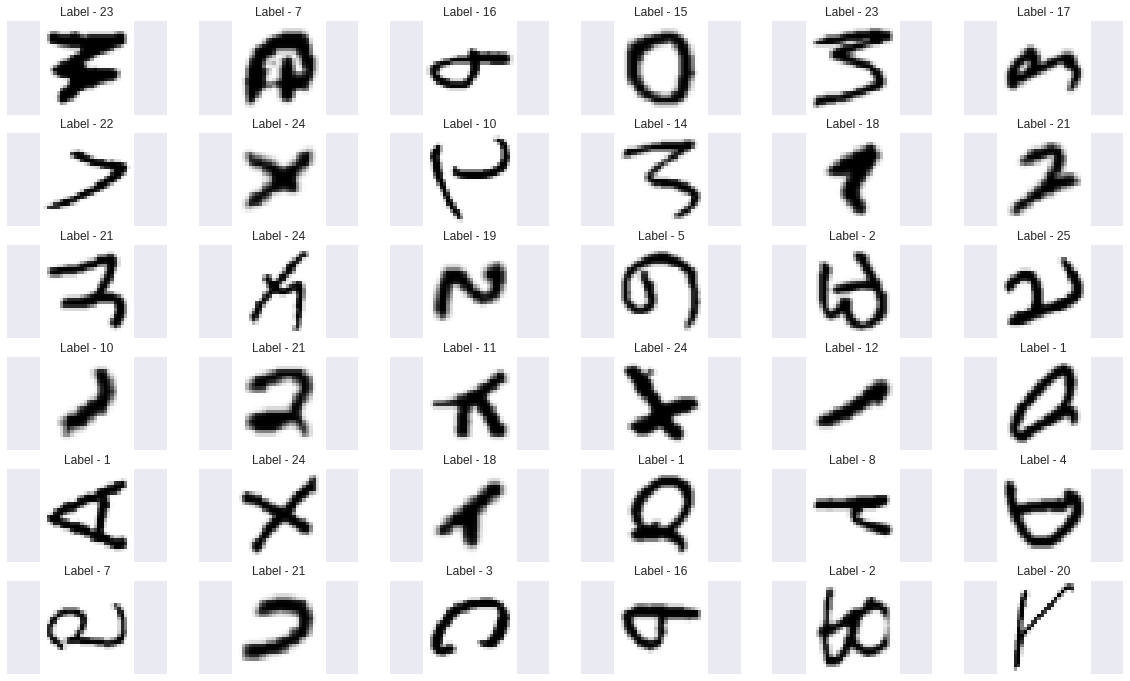

In [8]:
show_letters(X_train, y_train)

### Data Preprocessing

Normalization

In [9]:
print("Training data - before normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("\nTraining data - after normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

Training data - before normalization: 
 - min: 0.0
 - max: 255.0
Test data - after normalization: 
 - min: 0.0
 - max: 255.0

Training data - after normalization: 
 - min: 0.0
 - max: 1.0
Test data - after normalization: 
 - min: 0.0
 - max: 1.0


Fixing indices class numering

In [10]:
print("Labels before fixing has values from <1,26>:")
print("y_train values: {}".format(set(y_train)))
print("y_test values: {}".format(set(y_test)))

y_train = y_train - 1 
y_test = y_test - 1

print("Labels after fixing has values from <0,25>:")
print("y_train values: {}".format(set(y_train)))
print("y_test values: {}".format(set(y_test)))

Labels before fixing has values from <1,26>:
y_train values: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
y_test values: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
Labels after fixing has values from <0,25>:
y_train values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
y_test values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}


One-Hot Encoding

In [11]:
print("Train data labels - before OHE: ")
print(" - example: {}\n".format(y_train[:10]))
print("Test data labels - before OHE: ")
print(" - example: {}\n".format(y_test[:10]))


y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)

print("\nTrain data labels - after OHE: ")
print(" - example: {}\n".format(y_train[:10]))
print("Test data labels - after OHE: ")
print(" - example: {}\n".format(y_test[:10]))

Train data labels - before OHE: 
 - example: [22  6 15 14 22 16 12 10 21 23]

Test data labels - before OHE: 
 - example: [0 0 0 0 0 0 0 0 0 0]


Train data labels - after OHE: 
 - example: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

### Train/Validation data split

In [12]:
split_ratio = 0.8
split_index = int(X_train.shape[0] * split_ratio)

X_train_input, y_train_input = X_train[:split_index], y_train[:split_index]
X_val_input, y_val_input = X_train[split_index:], y_train[split_index:]

print("X_train_input shape: {}".format(X_train_input.shape))
print("y_train_input shape: {}".format(y_train_input.shape))
print("X_val_input shape: {}".format(X_val_input.shape))
print("y_val_input shape: {}".format(y_val_input.shape))

X_train_input shape: (99840, 28, 28, 1)
y_train_input shape: (99840, 26)
X_val_input shape: (24960, 28, 28, 1)
y_val_input shape: (24960, 26)


### Model

Creation

In [13]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding="same", use_bias=False,
                 input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS),
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, use_bias=False, 
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(NUM_LABELS, 
                activation="softmax",
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
    
model.compile(loss="categorical_crossentropy", optimizer=Adam(), 
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        288       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9216      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
__________

Training

In [0]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [15]:
history = model.fit(X_train_input, y_train_input,
                    batch_size=32,
                    epochs=100,
                    verbose=2,
                    callbacks=[EarlyStoppingByLossVal(monitor="val_loss", value=0.18, verbose=1)],
                    validation_data=(X_val_input, y_val_input))

Train on 99840 samples, validate on 24960 samples
Epoch 1/100
 - 64s - loss: 0.3463 - acc: 0.8875 - val_loss: 0.2941 - val_acc: 0.9048
Epoch 2/100
 - 62s - loss: 0.2051 - acc: 0.9290 - val_loss: 0.3533 - val_acc: 0.8873
Epoch 3/100
 - 62s - loss: 0.1730 - acc: 0.9390 - val_loss: 0.2236 - val_acc: 0.9248
Epoch 4/100
 - 62s - loss: 0.1527 - acc: 0.9443 - val_loss: 0.2127 - val_acc: 0.9292
Epoch 5/100
 - 62s - loss: 0.1380 - acc: 0.9490 - val_loss: 0.2256 - val_acc: 0.9274
Epoch 6/100
 - 62s - loss: 0.1254 - acc: 0.9534 - val_loss: 0.1884 - val_acc: 0.9378
Epoch 7/100
 - 62s - loss: 0.1145 - acc: 0.9559 - val_loss: 0.1795 - val_acc: 0.9409
Epoch 00006: early stopping THR


Evaluation

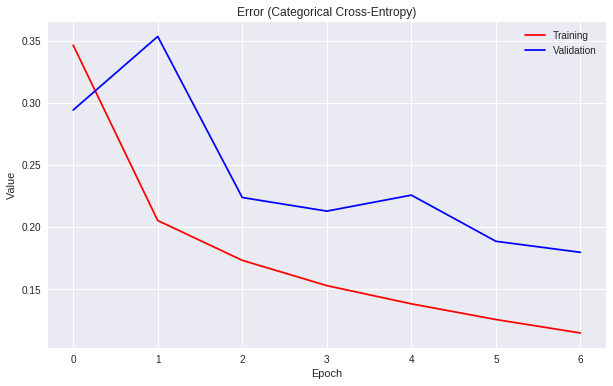

In [16]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(history.history["loss"], c="r")
ax.plot(history.history["val_loss"], c="b")
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");

In [17]:
train_score = model.evaluate(X_train_input, y_train_input, verbose=0)
val_score = model.evaluate(X_val_input, y_val_input, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
  
train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

val_score, val_accuracy = val_score
print("Validation data results:")
print(" - error: {}".format(val_score))
print(" - acc: {}".format(val_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 0.12124352676805873
 - acc: 0.9603465544871795
Validation data results:
 - error: 0.17949790517584635
 - acc: 0.9409455128205129
Test data results:
 - error: 0.19135448679023495
 - acc: 0.9378365384615385
